In [1]:
import time
import torch

/home/zhizhen/anaconda3/envs/neural_cbf/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch.nn as nn

In [3]:
# utilities
from cbfverify_barrier_fastlin import get_weights

In [4]:
# Output bounds, Batch
from cbfverify_barrier_fastlin_batch import get_barrier_bounds_fastlin_batch

# Output bounds, Original (Non-Batch)
from cbfverify_barrier_fastlin import get_barrier_bounds_fastlin

In [5]:
# Lie bounds, Batch (originally supported)
from cbfverify_lie import get_lie_derivative_bounds

In [6]:
# 1-layer network with ReLU activation
dim_in, dim_out, num_hidden, num_batch = 3, 1, 256, 1
model = nn.Sequential(
    nn.Linear(dim_in,num_hidden),
    nn.ReLU(),
    nn.Linear(num_hidden,dim_out)
)

In [7]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

Sequential(
  (0): Linear(in_features=3, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=1, bias=True)
)

In [8]:
Ws, bs = get_weights(model)

W0:torch.Size([256, 3])
b0:torch.Size([256])
W1:torch.Size([1, 256])
b1:torch.Size([1])


In [9]:
# 10k samples
num_sample = 10000
x0 = torch.rand(dim_in,num_sample) # shape: (dim_in, num_batch)

In [10]:
# perturbation magnitude
eps = 0.1

## Network Output Bounds, FastLin

In [11]:
start = time.time()
non_batch_UBs = []
non_batch_LBs = []
for i in range(x0.shape[1]):
    x = x0[:,[i]]
    UBs, LBs = get_barrier_bounds_fastlin(x, eps, Ws, bs, method="fastlin", activation="relu")
    non_batch_UBs.append(UBs[-1][0, 0])
    non_batch_LBs.append(LBs[-1][0, 0])
fastlin_elapsed_non_batch = time.time() - start

In [12]:
print("Time elapsed (non_batch version): {}".format(fastlin_elapsed_non_batch))

Time elapsed (non_batch version): 4.515855312347412


In [13]:
non_batch_UBs = torch.FloatTensor(non_batch_UBs)
non_batch_LBs = torch.FloatTensor(non_batch_LBs)

In [14]:
start = time.time()
UBs, LBs = get_barrier_bounds_fastlin_batch(x0, eps, Ws, bs, method="fastlin", activation="relu")
fastlin_elapsed_batch = time.time() - start

In [15]:
print("Time elapsed (batched version): {}".format(fastlin_elapsed_batch))

Time elapsed (batched version): 0.7702548503875732


In [16]:
batch_UBs = UBs[-1].squeeze()
batch_LBs = LBs[-1].squeeze()

In [17]:
batch_UBs

tensor([-0.0257,  0.1259,  0.1678,  ..., -0.0176,  0.0610,  0.1590])

In [18]:
batch_LBs

tensor([-0.1087,  0.0055,  0.0750,  ..., -0.0937, -0.0393,  0.0640])

### Check output bounds correctness

In [19]:
torch.allclose(non_batch_UBs, batch_UBs, atol=1e-07)

True

In [20]:
torch.allclose(non_batch_LBs, batch_LBs, atol=1e-07)

True

## Network Output Bounds, CROWN

In [21]:
start = time.time()
non_batch_UBs = []
non_batch_LBs = []
for i in range(x0.shape[1]):
    x = x0[:,[i]]
    UBs, LBs = get_barrier_bounds_fastlin(x, eps, Ws, bs, method="crown", activation="relu")
    non_batch_UBs.append(UBs[-1][0, 0])
    non_batch_LBs.append(LBs[-1][0, 0])
fastlin_elapsed_non_batch = time.time() - start

In [22]:
print("Time elapsed (non_batch version): {}".format(fastlin_elapsed_non_batch))

Time elapsed (non_batch version): 4.323939561843872


In [23]:
non_batch_UBs = torch.FloatTensor(non_batch_UBs)
non_batch_LBs = torch.FloatTensor(non_batch_LBs)

In [24]:
start = time.time()
UBs, LBs = get_barrier_bounds_fastlin_batch(x0, eps, Ws, bs, method="crown", activation="relu")
fastlin_elapsed_batch = time.time() - start

In [25]:
print("Time elapsed (batched version): {}".format(fastlin_elapsed_batch))

Time elapsed (batched version): 0.765021562576294


In [26]:
batch_UBs = UBs[-1].squeeze()
batch_LBs = LBs[-1].squeeze()

In [27]:
batch_UBs

tensor([-0.0250,  0.1228,  0.1636,  ..., -0.0199,  0.0626,  0.1565])

In [28]:
batch_LBs

tensor([-0.1078,  0.0067,  0.0785,  ..., -0.0923, -0.0330,  0.0648])

### Check output bounds correctness

In [29]:
torch.allclose(non_batch_UBs, batch_UBs, atol=1e-07)

True

In [30]:
torch.allclose(non_batch_LBs, batch_LBs, atol=1e-07)

True

### Comparison: batched FastLin vs batched ibp

In [31]:
from cbfverify_barrier_fastlin import get_barrier_bounds_ibp

In [32]:
start = time.time()
UBs, LBs = get_barrier_bounds_ibp(x0, eps, Ws, bs, activation="relu")
ibp_elapsed_batch = time.time() - start

In [33]:
print("Time elapsed (batched ibp): {}".format(ibp_elapsed_batch))

Time elapsed (batched ibp): 0.008853912353515625


In [34]:
print("UB: {}, LB: {}".format(UBs[-1][0][0], LBs[-1][0][0]))

UB: 0.13961906731128693, LB: -0.2757570743560791


In [35]:
start = time.time()
UBs, LBs = get_barrier_bounds_fastlin_batch(x0, eps, Ws, bs, method="fastlin", activation="relu")
fastlin_elapsed_batch = time.time() - start

In [36]:
print("Time elapsed (batched fastlin): {}".format(fastlin_elapsed_batch))

Time elapsed (batched fastlin): 0.7686493396759033


In [37]:
print("UB: {}, LB: {}".format(UBs[-1][0][0], LBs[-1][0][0]))

UB: -0.02567615546286106, LB: -0.10872718691825867


In [38]:
start = time.time()
UBs, LBs = get_barrier_bounds_fastlin_batch(x0, eps, Ws, bs, method="crown", activation="relu")
crown_elapsed_batch = time.time() - start

In [39]:
print("Time elapsed (batched crown): {}".format(crown_elapsed_batch))

Time elapsed (batched crown): 0.7635254859924316


In [40]:
print("UB: {}, LB: {}".format(UBs[-1][0][0], LBs[-1][0][0]))

UB: -0.025010153651237488, LB: -0.10784491896629333


## Lie Derivative Bounds

In [41]:
start = time.time()
non_batch_UBs = []
non_batch_LBs = []
for i in range(x0.shape[1]):
    x = x0[:,[i]]
    UBs, LBs = get_lie_derivative_bounds(x, eps, Ws, bs, activation="relu")
    non_batch_UBs.append(UBs[0])
    non_batch_LBs.append(LBs[0])
lie_elapsed_non_batch = time.time() - start

/home/zhizhen/Documents/Neural-Network-Certification-Tools/cbfverify_lie.py:78: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2318.)
  UB_3 = torch.matmul(UB_2.T,W_pos2.T)+torch.matmul(LB_2.T,W_neg2.T)


In [42]:
print("Time elapsed (non_batch_version): {}".format(lie_elapsed_non_batch))

Time elapsed (non_batch_version): 2.998300075531006


In [43]:
non_batch_UBs = torch.stack(non_batch_UBs).squeeze()
non_batch_LBs = torch.stack(non_batch_LBs).squeeze()

In [44]:
start = time.time()
UBs, LBs = get_lie_derivative_bounds(x0, eps, Ws, bs, activation="relu")
lie_elapsed_batched = time.time() - start

In [45]:
print("Time elapsed (batched version): {}".format(lie_elapsed_batched))

Time elapsed (batched version): 0.04903268814086914


In [46]:
batch_UBs = UBs.squeeze()
batch_LBs = LBs.squeeze()

### Check Lie bounds correctness

In [47]:
torch.allclose(non_batch_UBs, batch_UBs, atol=1e-07)

True

In [48]:
torch.allclose(non_batch_LBs, batch_LBs, atol=1e-07)

True

#### Check Lie propagation with ReLU

In [49]:
x0_in = x0.T
x0_in = x0_in.requires_grad_(True)

In [50]:
# Gradients given by pytorch's autograd
all_grads = []
for x0_single in x0_in:
    x0_single = x0_single.unsqueeze(0)
    grads = torch.autograd.grad(model(x0_single),x0_single)
    all_grads.append(grads[0])

In [51]:
autograd_res = torch.vstack(all_grads)

In [52]:
from cbfverify_lie import forward_prop_lie

In [53]:
# Our own propagation
all_grads = forward_prop_lie(Ws,bs,x0,activation='relu')

In [54]:
imp_res = all_grads.squeeze()

In [55]:
torch.allclose(autograd_res, imp_res, atol=1e-07)

True

#### Validate Lie derivative bounds

In [56]:
from cbfverify_lie import validate_bounds, show

In [57]:
violation_UBs, violation_LBs = validate_bounds(x0, eps, Ws, bs)

pass validation of UB!
pass validation of LB!


In [58]:
x0.shape

torch.Size([3, 10000])

In [59]:
import matplotlib.pyplot as plt

In [60]:
idx = 0

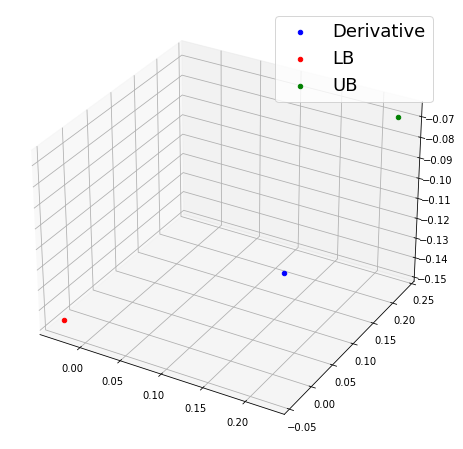

In [61]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.scatter(*imp_res[idx], c='b', label='Derivative')
ax.scatter(*batch_LBs[idx], c='r', label='LB')
ax.scatter(*batch_UBs[idx], c='g', label='UB')
plt.legend(fontsize=18)